# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [1]:
import twitter

CONSUMER_KEY = "eJgirrczqcBgSZOxoDZc6f0mo"
CONSUMER_SECRET = "uTAxvcA7hHwLEniZd0Ar85hl1wobZt8Zsz7TK2RcOtPjUHRFK8"

ACCESS_TOKEN_KEY = "1024438705-2Ky4WEhz876J10wXQbke9hOVFH8YmWJ30nMYRQN"
ACCESS_TOKEN_SECRET = "WtTK8qjXioXxdlGHuVQerj76W2oNhbbUG7qocPxPr6IXL"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

In [2]:
def get_user_tweets(user_id):
    reslist = []
    try:
        statuses = api.GetUserTimeline(user_id = user_id, count=200, trim_user=True, 
                                       exclude_replies=True, include_rts=False)
        for status in statuses:
            d = status.AsDict()
            if not ('retweeted_status' in d) and (d['lang']=='en'):
                res = {'lang': d['lang'], 
                 'favorited': d['favorite_count']>0 if 'favorite_count' in d else False, 
                 'truncated': d["truncated"] if "truncated" in d else False, 
                 'text': d['text'], 
                 'created_at': d['created_at'], 
                 'retweeted': d['retweet_count']>0 if 'retweet_count' in d else False, 
                 'source': d['source'] if 'source' in d else None, 
                 'user': d['user'], 
                 'id': d['id']}
                reslist.append(res)
    except twitter.TwitterError as err:
        if err.message=="Rate limit exceeded":
            raise
        if err.message!="Not authorized.":
            print "\nError: ",err
        return reslist
    return reslist

In [3]:
get_user_tweets(1535215357)

[{'created_at': u'Thu Nov 17 01:06:44 +0000 2016',
  'favorited': False,
  'id': 799056140264935424L,
  'lang': u'en',
  'retweeted': False,
  'source': u'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'text': u"I'm watching Michael's last episode of the office and I'm seriously about to cry \U0001f62d",
  'truncated': False,
  'user': {u'id': 1535215357}}]

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
import unicodedata
import nltk
import re

def is_nonword(s):
    badwords = ["http://","https://","@","#"]
    for w in badwords:
        if s.count(w)>0:
            return True
    return False
def remove_nonwords(text):
    spl_text = text.split(" ")
    return " ".join(s for s in spl_text if not is_nonword(s))
def get_words(text):
    """returns list of words"""
    lower_str = text.lower()
    normstr = ''.join(c for c in unicodedata.normalize('NFD',lower_str) if not unicodedata.combining(c))
    normstr = remove_nonwords(normstr)
    return re.findall(r"[a-z]\w+",normstr)

In [5]:
print get_words(u"Here are 8 different words! http://smth.com @smth #smth")

[u'here', u'are', u'different', u'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [6]:
import nltk
nltk.download(['stopwords', 'wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [7]:
stopwords = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.SnowballStemmer('english')
def get_tokens(words):
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = []
    for word in words:
        norm_word = lemmatizer.lemmatize(word)
        #norm_word = stemmer.stem(norm_word)
        if not (norm_word in stopwords):
            tokens.append(norm_word)
    return tokens

In [8]:
print get_tokens(["here", "are", "different", "words"])

['different', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [9]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

In [10]:
#get_user_tweets(101229079)

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [13]:
import json
import os
import numpy
class MyEncoder(json.JSONEncoder): #json.dump не декодировал numpy.int64
    def default(self, obj):
        if isinstance(obj, numpy.integer):
            return int(obj)
        elif isinstance(obj, numpy.floating):
            return float(obj)
        elif isinstance(obj, numpy.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)
def load_cache(tmp_file_name):
    users = []
    processed_users = []
    features = []
    if os.path.exists(tmp_file_name):
        with open(tmp_file_name) as f:
            for line in f:
                try:
                    uid, feat = json.loads(line)
                    processed_users.append(uid)
                    if feat:
                        users.append(uid)
                        features.append(feat)
                except:
                    continue
    return processed_users,users,features
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    uids = df_users['uid'].values
    tmp_file_name = 'tmp_user_records.json'
    processed_users,users,features = load_cache(tmp_file_name)
    with open(tmp_file_name, 'a') as tmp_file:
        for uid_ind, uid in enumerate(uids) :
            print '\rProcessed %d of %d users'%(uid_ind,len(uids)),
            if not (uid in processed_users):
                #print "\n"
                #print type(uid) 
                tweets = get_user_tweets(uid)
                tokendict = {}
                for tweet in tweets:
                    tokens = get_tweet_tokens(tweet['text'])
                    words_set = set(tokens)
                    for word in words_set:
                        if word in tokendict:
                            tokendict[word]+=tokens.count(word)
                        else:
                            tokendict[word]=tokens.count(word)
                if len(tokendict.keys())>0:
                    users.append(uid)
                    features.append(tokendict)
                json.dump([uid,tokendict],tmp_file, cls=MyEncoder)
                tmp_file.write(u'\n')
    print "\rProcessed %d of %d users\nDone"%(len(uids),len(uids))
    return users, features

In [14]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_PATH = "train.csv"
TESTING_SET_PATH = "test.csv"
df_users_train = pd.read_csv(TRAINING_SET_PATH, sep=",", header=0)
df_users_ex = pd.read_csv(TESTING_SET_PATH, sep=",", header=0)
df_users_ex['cls'] = None
df_users = pd.concat([df_users_train, df_users_ex])
try:
    users, users_tokens = collect_users_tokens(df_users)
except twitter.TwitterError:
    print "Limit reached, please change account or retry in several minutes"
else:
    v = DictVectorizer()
    vs = v.fit_transform(users_tokens)

Processed 11947 of 11947 users
Done


In [15]:
numpy.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""
    wcloud = WordCloud(background_color="white", max_words=200, width=1280, height=800)
    words = v.get_feature_names()
    freqs = numpy.squeeze(numpy.asarray(vs.sum(axis=0)))
    plt.figure(figsize=(15,8))
    plt.axis("off")
    plt.imshow(wcloud.generate_from_frequencies(zip(words, freqs)))
    plt.show()

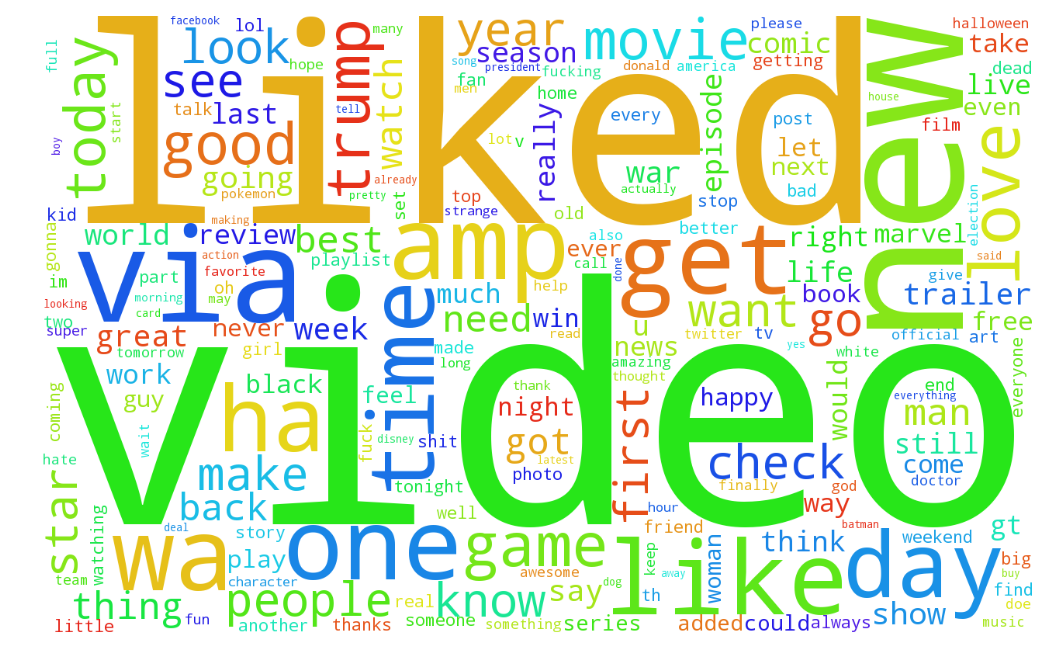

In [25]:
draw_tag_cloud(v, vs)